In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import dask.dataframe as dd
from tqdm import tqdm
import scipy.stats as sct
#from prose.fluxes import Fluxes
#from prose import Sequence, blocks
from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages
#from scipy.signal import lombscargle as lbsc
import pickle
from astropy.timeseries import LombScargle

In [2]:
with open('time.dat', 'r') as file:
    lineas = file.readlines()
time = np.zeros(len(lineas))
for i in range(len(lineas)):
    if i==0:
        time[i] = np.nan
    else:
        time[i] = float(lineas[i].strip())

In [3]:
with open('resultado.csv', 'r') as file:
    lineas= file.readlines()
    
stars_o = []
for i, linea in tqdm(enumerate(lineas)):
    if i == 0:
        header = np.array(linea.split(','), dtype=str) 
    if i > 0:
        valores=linea.split(',')
        lista = []
        for valor in valores:
            if (valor.strip() != '') and (valor.strip() != 'INDEF'):
                lista.append(float(valor))
            
            else:
                lista.append(np.nan)
            
        
        del lista[12] #elimina valor 'separation'
        star = np.array(lista)
        stars_o.append(star)

19711it [01:29, 219.27it/s]


In [4]:
stars = stars_o.copy()

In [5]:
flux = []
mag = []
merr = []
ids = []
xcoords = []
ycoords = []
for i in tqdm(range(len(stars))):
    ftemp = []
    mgtemp = []
    mrtemp = []
    idtemp = []
    xcootemp = []
    ycootemp = []
    for j in range(len(stars[i])):
        
        if j%6 == 0:
            idtemp.append(stars[i][j])
        if j%6 == 1:
            xcootemp.append(stars[i][j])
        if j%6 == 2:
            ycootemp.append(stars[i][j])
        if j%6 == 3:
            ftemp.append(stars[i][j])   
        if j%6 == 4:
            mgtemp.append(stars[i][j])
        if j%6 == 5:
            mrtemp.append(stars[i][j])  
            
    len_sin_nan = np.count_nonzero(~np.isnan(mgtemp))
    if len_sin_nan >= 63: 
        
        ids.append(np.array(idtemp))
        flux.append(np.array(ftemp))
        mag.append(np.array(mgtemp))
        merr.append(np.array(mrtemp))
        xcoords.append(np.array(xcootemp))
        ycoords.append(np.array(ycootemp))

100%|███████████████████████████████████████████████████████████████████████████| 19710/19710 [01:31<00:00, 215.80it/s]


In [6]:
idsM = [ids[i][0] for i in range(len(ids))]
XcooM = [xcoords[i][0] for i in range(len(xcoords))]
YcooM = [ycoords[i][0] for i in range(len(ycoords))]

In [28]:
print(idsM[8398], XcooM[8398], YcooM[8398], mag[8398][100], merr[8398][100])

9450.0 2614.604 3048.809 19.297 0.065


In [27]:
idsM.index(9450.0)

8398

In [26]:
with open("mag.pickle", "wb") as f:
    pickle.dump(mag, f)
    
with open("merr.pickle", "wb") as f:
    pickle.dump(merr, f)
    
with open("flux.pickle", "wb") as f:
    pickle.dump(flux, f)
    
with open("idsM.pickle", "wb") as f:
    pickle.dump(idsM, f)
    
with open("xcoo.pickle", "wb") as f:
    pickle.dump(XcooM, f)
    
with open("ycoo.pickle", "wb") as f:
    pickle.dump(YcooM, f)
    
with open("time.pickle", "wb") as f:
    pickle.dump(time, f)

In [ ]:
with open("mag.pickle", "rb") as f:
    mag = pickle.load(f)
with open("merr.pickle", "rb") as f:
    merr = pickle.load(f)
with open("flux.pickle", "rb") as f:
    flux = pickle.load(f)
with open("ids.pickle", "rb") as f:
    idsM = pickle.load(f)
with open("xcoo.pickle", "rb") as f:
    XcooM = pickle.load(f)
with open("ycoo.pickle", "rb") as f:
    YcooM = pickle.load(f)
with open("time.pickle", "rb") as f:
    time = pickle.load(f)

In [29]:
desv = []
prom = []
for i in tqdm(range(len(mag))):
    prom.append(np.nanmean(mag[i]))
    desv.append(np.nanstd(mag[i]))

100%|██████████████████████████████████████████████████████████████████████████| 14637/14637 [00:02<00:00, 6500.94it/s]


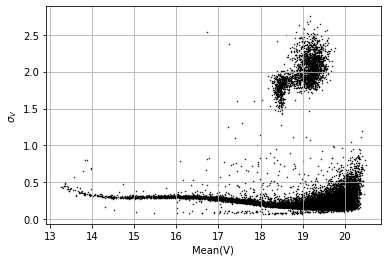

In [30]:
plt.scatter(prom, desv, c='k', s=0.25)
plt.xlabel('Mean(V)')
plt.ylabel(r'$\sigma_{V}$')
plt.grid()

In [89]:
mag_1 = mag[0:3655]
mag_2 = mag[3655:7309]
mag_3 = mag[7309: 10965]
mag_4 = mag[10965:]

ids_1 = idsM[0:3655]
ids_2 = idsM[3655:7309]
ids_3 = idsM[7309: 10965]
ids_4 = idsM[10965:]

In [106]:
with PdfPages('MagBoxStilts_4.pdf') as pdf: 
    for i, magt in tqdm(enumerate(mag_4)):
        datos = [value for value in magt if not np.isnan(value)]
        if i%4 == 0:
            fig, axs = plt.subplots(2, 2, figsize=(10, 8))
            
        fila = i%2 #se decide si el plot estará arriba o abajo
        columna = (i // 2)%2
        
        axs[fila, columna].boxplot(datos)
        axs[fila, columna].invert_yaxis()
        axs[fila, columna].set_ylabel('V')
        axs[fila, columna].set_title(f'ID_{ids_4[i]}, i={i}')
        
        if (i+1) % 4==0 or (i+1)==len(mag_4):
            pdf.savefig(fig)
            plt.close(fig)

3672it [04:16, 14.33it/s]


In [35]:
def elimatp(mag, merr, flux, time):
    data = [value for value in mag if not np.isnan(value)]
    boxplot = plt.boxplot([data])
    atpos = [item.get_ydata() for item in boxplot['fliers']]
    magt = []
    merrt = []
    fluxt = []
    timet = []
    for i in range(len(mag)):
        if mag[i] not in atpos[0]:
            magt.append(mag[i])
            merrt.append(merr[i])
            fluxt.append(flux[i])
            timet.append(time[i])
    magt = np.array(magt)
    merrt = np.array(merrt)
    fluxt = np.array(fluxt)
    timet = np.array(timet)
    return magt, merrt, fluxt, timet

In [108]:
mag1 = []
merr1 = []
flux1 = []
ids1 = []
time1 = []
xcoo1 = []
ycoo1 = []
for i in tqdm(range(len(mag))):
    magt, merrt, fluxt, timet = elimatp(mag[i], merr[i], flux[i], time)
    len_sin_nan = np.count_nonzero(~np.isnan(magt))
    if len_sin_nan >= 63:
        mag1.append(magt)
        merr1.append(merrt)
        flux1.append(fluxt)
        ids1.append(idsM[i])
        time1.append(timet)
        xcoo1.append(XcooM[i])
        ycoo1.append(YcooM[i])
plt.close()

100%|████████████████████████████████████████████████████████████████████████████| 14637/14637 [04:17<00:00, 56.78it/s]


In [109]:
with open("mag_1.pickle", "wb") as f:
    pickle.dump(mag1, f)
    
with open("merr_1.pickle", "wb") as f:
    pickle.dump(merr1, f)
    
with open("flux_1.pickle", "wb") as f:
    pickle.dump(flux1, f)
    
with open("ids_1.pickle", "wb") as f:
    pickle.dump(ids1, f)
    
with open("time_1.pickle", "wb") as f:
    pickle.dump(time1, f)
    
with open("xcoo_1.pickle", "wb") as f:
    pickle.dump(xcoo1, f)
    
with open("ycoo_1.pickle", "wb") as f:
    pickle.dump(ycoo1, f)   

In [110]:
with open("mag_1.pickle", "rb") as f:
    mag1 = pickle.load(f)
with open("merr_1.pickle", "rb") as f:
    merr1 = pickle.load(f)
with open("flux_1.pickle", "rb") as f:
    flux1 = pickle.load(f)
with open("ids_1.pickle", "rb") as f:
    ids1 = pickle.load(f)
with open("time_1.pickle", "rb") as f:
    time1 = pickle.load(f)
with open("xcoo_1.pickle", "rb") as f:
    xcoo1 = pickle.load(f)
with open("ycoo_1.pickle", "rb") as f:
    ycoo1 = pickle.load(f)

In [111]:
desv1 = []
prom1 = []
for i in tqdm(range(len(mag1))):
    prom1.append(np.nanmean(mag1[i]))
    desv1.append(np.nanstd(mag1[i]))

100%|██████████████████████████████████████████████████████████████████████████| 14530/14530 [00:02<00:00, 6619.36it/s]


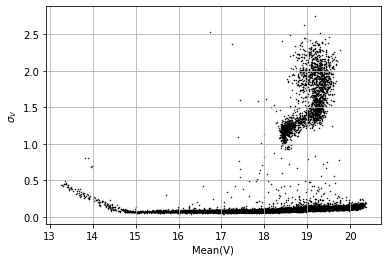

In [41]:
plt.scatter(prom1, desv1, c='k', s=0.25)
plt.xlabel('Mean(V)')
plt.ylabel(r'$\sigma_{V}$')
plt.grid()

In [43]:
len(prom1)

14530

In [112]:
def filtrarMag(mag, merr, ids, flux, prom, desv, time, xcoo, ycoo):
    
    magt = []
    merrt = []
    idst = []
    fluxt = []
    promt = []
    desvt = []
    timet = []
    xcoot = []
    ycoot = []
    
    for i in tqdm(range(len(prom))):
        if (prom[i] >= 15.0) and (desv[i] < 1.0) :
            magt.append(mag[i])
            merrt.append(merr[i])
            idst.append(ids[i])
            fluxt.append(flux[i])
            promt.append(prom[i])
            desvt.append(desv[i])
            timet.append(time[i])
            xcoot.append(xcoo[i])
            ycoot.append(ycoo[i])
            
        
    return magt, merrt, idst, fluxt, promt, desvt, timet, xcoot, ycoot

In [113]:
mag2, merr2,  ids2, flux2, prom2, desv2, time2, xcoo2, ycoo2 = filtrarMag(mag1, merr1, ids1, flux1, prom1, desv1, time1, xcoo1, ycoo1)

100%|████████████████████████████████████████████████████████████████████████| 14530/14530 [00:00<00:00, 350873.61it/s]


In [114]:
desv2 = []
prom2 = []
for i in tqdm(range(len(mag2))):
    prom2.append(np.nanmean(mag2[i]))
    desv2.append(np.nanstd(mag2[i]))

100%|██████████████████████████████████████████████████████████████████████████| 12408/12408 [00:01<00:00, 6670.65it/s]


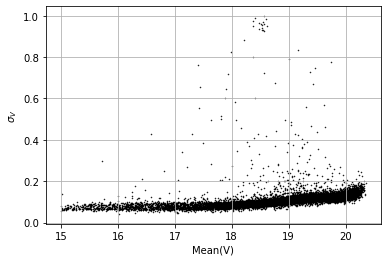

In [55]:
plt.scatter(prom2, desv2, c='k', s=0.25)
plt.xlabel('Mean(V)')
plt.ylabel(r'$\sigma_{V}$')
plt.grid()

In [115]:
with open("mag_2.pickle", "wb") as f:
    pickle.dump(mag2, f)
with open("merr_2.pickle", "wb") as f:
    pickle.dump(merr2, f)
with open("ids_2.pickle", "wb") as f:
    pickle.dump(ids2, f)
with open("flux_2.pickle", "wb") as f:
    pickle.dump(flux2, f)
with open("time_2.pickle", "wb") as f:
    pickle.dump(time2, f)
with open("prom_2.pickle", "wb") as f:
    pickle.dump(prom2, f)
with open("desv_2.pickle", "wb") as f:
    pickle.dump(desv2, f)
with open("xcoo_2.pickle", "wb") as f:
    pickle.dump(xcoo2, f)
with open("ycoo_2.pickle", "wb") as f:
    pickle.dump(ycoo2, f) 

In [116]:
with open("mag_2.pickle", "rb") as f:
    mag2 = pickle.load(f)
with open("merr_2.pickle", "rb") as f:
    merr2 = pickle.load(f)
with open("ids_2.pickle", "rb") as f:
    ids2 = pickle.load(f)
with open("flux_2.pickle", "rb") as f:
    flux2 = pickle.load(f)
with open("time_2.pickle", "rb") as f:
    time2 = pickle.load(f)
with open("prom_2.pickle", "rb") as f:
    prom2 = pickle.load(f)
with open("desv_2.pickle", "rb") as f:
    desv2 = pickle.load(f)
with open("xcoo_2.pickle", "rb") as f:
    xcoo2 = pickle.load(f)
with open("ycoo_2.pickle", "rb") as f:
    ycoo2 = pickle.load(f)

In [57]:
def func(x, b, c, d):
    return b*x**2 + c*x + d
popt, pcov = curve_fit(func, prom2, desv2)
b, c, d = popt

In [58]:
fit = 1.25*func(np.array(prom2), b, c, d)
popt*1.25

array([ 0.00308965, -0.09264334,  0.78541701])

Text(0, 0.5, '$\\sigma_{promV}$')

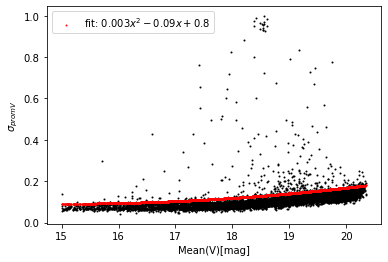

In [59]:
plt.scatter(prom2, desv2, s=1, c='k')
plt.scatter(prom2,1.25*func(np.array(prom2), b, c, d), s=0.8, c='r', label=r'fit: $ 0.003x^2 - 0.09x + 0.8$')
plt.legend()
plt.xlabel(r'Mean(V)[mag]')
plt.ylabel(r'$\sigma_{promV}$')

In [117]:
def filtrarfit(fit, mag, merr, ids, flux, prom, desv, time, xcoo, ycoo):
    magt = []
    merrt = []
    idst = []
    fluxt = []
    promt = []
    desvt = []
    timet = []
    xcoot = []
    ycoot = []
    for i in tqdm(range(len(prom))):
        if (desv[i] > fit[i]):
            magt.append(mag[i])
            merrt.append(merr[i])
            idst.append(ids[i])
            fluxt.append(flux[i])
            promt.append(prom[i])
            desvt.append(desv[i])
            timet.append(time[i])
            xcoot.append(xcoo[i])
            ycoot.append(ycoo[i])
            
        
    return magt, merrt, idst, fluxt, promt, desvt, timet, xcoot, ycoot

In [118]:
mag3, merr3, ids3, flux3, prom3, desv3, time3, xcoo3, ycoo3= filtrarfit(fit, mag2, merr2, ids2, flux2, prom2, desv2, time2, xcoo2, ycoo2) 

100%|████████████████████████████████████████████████████████████████████████| 12408/12408 [00:00<00:00, 728188.78it/s]


Text(0, 0.5, '$\\sigma_{promV}$')

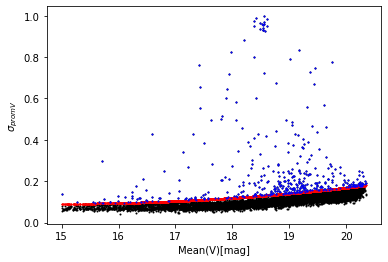

In [68]:
plt.scatter(prom2, desv2, s=1, c='k')
plt.scatter(prom2,1.25*func(np.array(prom2), b, c, d), s=0.6, c='r')
plt.scatter(prom3, desv3, s=1, c='b')
plt.xlabel(r'Mean(V)[mag]')
plt.ylabel(r'$\sigma_{promV}$')

In [119]:
with open("mag_3.pickle", "wb") as f:
    pickle.dump(mag3, f)
with open("merr_3.pickle", "wb") as f:
    pickle.dump(merr3, f)
with open("ids_3.pickle", "wb") as f:
    pickle.dump(ids3, f)
with open("flux_3.pickle", "wb") as f:
    pickle.dump(flux3, f)
with open("time_3.pickle", "wb") as f:
    pickle.dump(time3, f)
with open("prom_3.pickle", "wb") as f:
    pickle.dump(prom3, f)
with open("desv_3.pickle", "wb") as f:
    pickle.dump(desv3, f)
with open("xcoo_3.pickle", "wb") as f:
    pickle.dump(xcoo3, f)
with open("ycoo_3.pickle", "wb") as f:
    pickle.dump(ycoo3, f)

In [ ]:
with open("mag_3.pickle", "rb") as f:
    mag3 = pickle.load(f)
with open("merr_3.pickle", "rb") as f:
    merr3 = pickle.load(f)
with open("ids_3.pickle", "rb") as f:
    ids3 = pickle.load(f)
with open("flux_3.pickle", "rb") as f:
    flux3 = pickle.load(f)
with open("time_3.pickle", "rb") as f:
    time3 = pickle.load(f)
with open("prom_3.pickle", "rb") as f:
    prom3 = pickle.load(f)
with open("desv_3.pickle", "rb") as f:
    desv3 = pickle.load(f)
with open("xcoo_3.pickle", "rb") as f:
    xcoo3 = pickle.load(f)
with open("ycoo_3.pickle", "rb") as f:
    ycoo3 = pickle.load(f)

In [120]:
def datasinnan(mag, merr, flux, time):
    magt = []
    merrt = []
    fluxt = []
    timet = []
    for i in range(len(mag)):
        if (np.isnan(mag[i]) == False) and (np.isnan(time[i]) == False):
            timet.append(time[i])
            fluxt.append(flux[i])
            magt.append(mag[i])
            merrt.append(merr[i])

           
    return magt, merrt, fluxt, timet

In [121]:
time4 = []
mag4 = []
merr4 = []
flux4 = []
ids4 = ids3
prom4 = prom3
desv4= desv3
xcoo4 = xcoo3
ycoo4 = ycoo3
for i in tqdm(range(len(mag3))):
    magt, merrt, fluxt, timet = datasinnan(mag3[i], merr3[i],  flux3[i], time3[i])
    time4.append(np.array(timet))
    mag4.append(np.array(magt))
    merr4.append(np.array(merrt))
    flux4.append(np.array(fluxt))

100%|███████████████████████████████████████████████████████████████████████████████| 423/423 [00:01<00:00, 239.60it/s]


In [122]:
with open("mag_4.pickle", "wb") as f:
    pickle.dump(mag4, f)
with open("merr_4.pickle", "wb") as f:
    pickle.dump(merr4, f)
with open("ids_4.pickle", "wb") as f:
    pickle.dump(ids4, f)
with open("flux_4.pickle", "wb") as f:
    pickle.dump(flux4, f)
with open("time_4.pickle", "wb") as f:
    pickle.dump(time4, f)
with open("prom_4.pickle", "wb") as f:
    pickle.dump(prom4, f)
with open("desv_4.pickle", "wb") as f:
    pickle.dump(desv4, f)
with open("xcoo_4.pickle", "wb") as f:
    pickle.dump(xcoo4, f)
with open("ycoo_4.pickle", "wb") as f:
    pickle.dump(ycoo4, f)

In [ ]:
with open("mag_4.pickle", "rb") as f:
    mag4 = pickle.load(f)
with open("merr_4.pickle", "rb") as f:
    merr4 = pickle.load(f)
with open("ids_4.pickle", "rb") as f:
    ids4 = pickle.load(f)
with open("flux_4.pickle", "rb") as f:
    flux4 = pickle.load(f)
with open("time_4.pickle", "rb") as f:
    time4 = pickle.load(f)
with open("prom_4.pickle", "rb") as f:
    prom4 = pickle.load(f)
with open("desv_4.pickle", "rb") as f:
    desv4 = pickle.load(f)
with open("xcoo_4.pickle", "rb") as f:
    xcoo4 = pickle.load(f)
with open("ycoo_4.pickle", "rb") as f:
    ycoo4 = pickle.load(f)

In [74]:
with PdfPages('magTstiltsSet4.pdf') as pdf: 
    for i in tqdm(range(len(mag4))): 
        plt.scatter(time4[i], mag4[i], c='k', s=0.8) 
        plt.gca().invert_yaxis()
        plt.xlabel('HJD')
        plt.ylabel('V')
        plt.title( f'ID_{ids4[i]}, i={i}') 
        pdf.savefig()
        plt.close()

100%|████████████████████████████████████████████████████████████████████████████████| 423/423 [00:44<00:00,  9.57it/s]


In [75]:
#funciones para Lombscargle
def darfase(T, t0, P):
    f = np.zeros(len(T))
    i = 0
    for t in T:
        if np.isnan(t)==True:
            t = 0
        a = (t - t0)/P
        b = int((t - t0)/P)
        f[i] = a-b
        i+=1
    return f

def darfrec(t):
    fmax = 1/(1.1/24)
    fmin = 1/9.9
    
    return fmin, fmax

def darDatos(t, t0, m, merr):
    
    fmin, fmax = darfrec(t)
    
    ls = LombScargle(t, m, merr)
    f, pw = ls.autopower(minimum_frequency=fmin, maximum_frequency=fmax)
    
    s95 = ls.false_alarm_level(0.05)
    s99 = ls.false_alarm_level(0.01)
    pwarr = np.sort(pw)
    pint = pwarr[-5:]
    ub = np.where(np.isin(pw, pint))[0]
    fmax = f[ub]
    p = 1/fmax
    Fase=[]
    for i in range(len(p)):
        Fase.append(darfase(t, 0, p[i]))
    
    return pw, f, Fase, p, s95, s99

In [76]:
pw = []
fases = []
fre = []
p = []
s95 = []
s99 = []

for i in tqdm(range(len(mag4))):
    pw1, fre1, fase1,  p1, s951, s991 = darDatos(time4[i], 0, mag4[i], merr4[i])
    pw.append(pw1)
    fases.append(fase1)
    fre.append(fre1)
    p.append(p1)
    s95.append(s951)
    s99.append(s991) 

 21%|████████████████▊                                                                | 88/423 [00:02<00:10, 31.09it/s]C:\Users\ThinkPad\Downloads\anaconda\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:251: RuntimeWarning: invalid value encountered in sqrt
  * np.sqrt(0.5 * NH * Z))
100%|████████████████████████████████████████████████████████████████████████████████| 423/423 [00:13<00:00, 31.12it/s]


In [77]:
with open("pw.pickle", "wb") as f:
    pickle.dump(pw, f)
with open("fases.pickle", "wb") as f:
    pickle.dump(fases, f)
with open("fre.pickle", "wb") as f:
    pickle.dump(fre, f)
with open("period.pickle", "wb") as f:
    pickle.dump(p, f)
with open("sig95.pickle", "wb") as f:
    pickle.dump(s95, f)
with open("sig99.pickle", "wb") as f:
    pickle.dump(s99, f)

In [ ]:
with open("pw.pickle", "rb") as f:
    pw = pickle.load(f)
with open("fases.pickle", "rb") as f:
    fases = pickle.load(f)
with open("fre.pickle", "rb") as f:
    fre = pickle.load(f)
with open("period.pickle", "rb") as f:
    p = pickle.load(f)
with open("sig95.pickle", "rb") as f:
    s95 = pickle.load(f)
with open("sig99.pickle", "rb") as f:
    s99 = pickle.load(f)

In [78]:
with PdfPages('CurvasDao.pdf') as pdf:
    for i in tqdm(range(len(mag4))):
        fig, axs = plt.subplots(2, 3, figsize=(10,6))
        
        axs[0, 0].plot(fre[i], pw[i], c='k', linewidth=0.5)
        print(ids4[i])
        axs[0, 0].set_title( f'ID_{ids4[i]}, i={i}')
        axs[0, 0].set_xlabel('Frequency')
        axs[0, 0].set_ylabel('Power')
        axs[0, 0].axhline(s95[i], color='r', linestyle='--', label='FAL = 0.05')
        axs[0, 0].axhline(s99[i], color='b', linestyle='--',  label='FAL = 0.01')
        axs[0, 0].legend()
        
        for j, periodo in enumerate(p[i]):
            if j<2:
                for k in [-1, 0, 1]:
                    axs[0, j+1].scatter(fases[i][j]+k, mag4[i], s=1, c="darkred")
                axs[0, j+1].invert_yaxis()
                axs[0, j+1].set_xlabel('Fase')
                axs[0, j+1].set_ylabel('V')
                axs[0, j+1].set_title(f'Periodo={round(p[i][j], 3)}[d]')
            else:
                for k in [-1, 0, 1]:
                    axs[1, j-2].scatter(fases[i][j]+k, mag4[i], s=1, c="darkred")
                axs[1, j-2].invert_yaxis()
                axs[1, j-2].set_xlabel('Fase')
                axs[1, j-2].set_ylabel('V')
                axs[1, j-2].set_title(f'Periodo={round(p[i][j], 3)}[d]')
        
        plt.tight_layout()
        pdf.savefig()
        plt.close()

100%|████████████████████████████████████████████████████████████████████████████████| 423/423 [05:34<00:00,  1.27it/s]


In [81]:
ids4[179]

6108.0